# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
book_cost=pd.read_excel("Book Cost.xlsx",index_col='Ticker')

In [7]:
quantities_api=Binance.binance_api.user_asset()
quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
quantities['asset']=quantities['asset']+'USDT'
quantities=quantities.set_index('asset')

In [8]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [9]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

In [10]:
pnl=pd.concat([book_cost,holding.loc[condition]],axis=1)
pnl['Book Cost']=(pnl['Book Cost']*quantities['free'].astype(float))
pnl['Profit and Loss']=pnl['Price in USDT']-pnl['Book Cost']
pnl.loc['Total']=pnl.sum()
pnl.round(4)

,Book Cost,Price in USDT,Weights in %,Profit and Loss
BTCUSDT,703.3655,604.8752,0.3344,-98.4903
TRXUSDT,318.6884,289.2818,0.1599,-29.4066
JASMYUSDT,453.8661,254.0670,0.1405,-199.7990
SOLUSDT,261.7091,236.1057,0.1305,-25.6033
OMUSDT,233.0309,224.6460,0.1242,-8.3850
ETHUSDT,264.2048,162.7324,0.0900,-101.4724
BBUSDT,46.3321,36.9958,0.0205,-9.3363
BNBUSDT,0.0271,0.0224,0.0000,-0.0047
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
Total,2281.2238,1808.7263,1.0000,-472.4975


In [11]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [12]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [13]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [14]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [15]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [16]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
2024-09-02 00:00:00
LDUMAUSDT not retrieved
LDTRXUSDT not retrieved
LDUMAUSDT
LDTRXUSDT


In [17]:
positions=positions.sort_index()

In [18]:
positions.index=pd.to_datetime(positions.index)

In [19]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [20]:
positions.to_excel('Positions.xlsx')

In [21]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [22]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [23]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [24]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [25]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [26]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [27]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

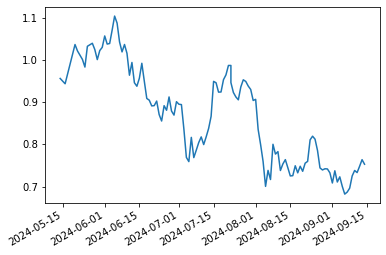

In [28]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [29]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [30]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [31]:
returns_to_use.columns

Index(['1000SATSUSDT', 'AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'CFXUSDT', 'CKBUSDT', 'DOGEUSDT', 'DOTUSDT',
       'EGLDUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT',
       'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT',
       'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT',
       'LINKUSDT', 'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT',
       'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SEIUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT',
       'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT',
       'WLDUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [32]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [33]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
OMUSDT,0.468407
BTCUSDT,0.400000
BNBUSDT,0.077715
PEPEUSDT,0.041218
CKBUSDT,0.007603
JASMYUSDT,0.005056


In [34]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [35]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
TRXUSDT,0.761364
OMUSDT,0.238636


## Real Portfolio vs Optimal

In [36]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison['Weights in %']=current_holding_comparison['Weights in %'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,604.875181,0.334421,0.000000,0.000000
TRXUSDT,289.281764,0.159937,0.761364,-0.601427
JASMYUSDT,254.067030,0.140467,0.000000,0.000000
SOLUSDT,236.105732,0.130537,0.000000,0.000000
OMUSDT,224.645959,0.124201,0.238636,-0.114435
ETHUSDT,162.732413,0.089971,0.000000,0.000000
BBUSDT,36.995796,0.020454,0.000000,0.000000
BNBUSDT,0.022403,0.000012,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


In [37]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison['Weights in %']=historical_comparison['Weights in %'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,604.875181,0.334421,0.400000,-0.065579
TRXUSDT,289.281764,0.159937,0.000000,0.000000
JASMYUSDT,254.067030,0.140467,0.005056,0.135411
SOLUSDT,236.105732,0.130537,0.000000,0.000000
OMUSDT,224.645959,0.124201,0.468407,-0.344206
ETHUSDT,162.732413,0.089971,0.000000,0.000000
BBUSDT,36.995796,0.020454,0.000000,0.000000
BNBUSDT,0.022403,0.000012,0.077715,-0.077703
PEPEUSDT,0.000002,0.000000,0.041218,-0.041218
CKBUSDT,0.000000,0.000000,0.007603,0.000000


# Risk Reward Analysis

In [38]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [39]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

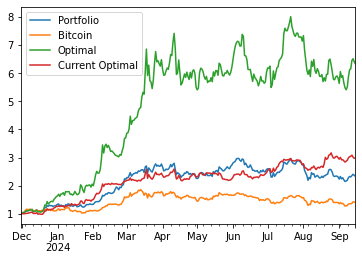

In [40]:
(1+portfolio_perf.iloc[:]).cumprod().plot()

In [41]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

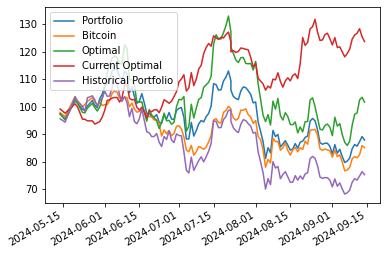

In [42]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [43]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-09-05,81.886389,79.925891,89.831112,119.884382,70.104808
2024-09-06,79.734831,76.707855,87.065641,118.081739,68.257851
2024-09-07,80.223438,76.988639,85.892685,119.282195,68.741021
2024-09-08,81.318169,77.990056,87.434642,120.860372,69.673872
2024-09-09,84.726881,81.017786,93.226089,124.498118,72.547158
2024-09-10,86.247818,81.857078,97.180193,125.989652,73.847140
2024-09-11,85.656782,81.432763,97.753018,126.645069,73.353880
2024-09-12,87.316008,82.553132,102.447668,128.281897,74.832363
2024-09-13,89.140103,85.846054,103.399678,125.396063,76.402057
2024-09-14,87.889403,85.126499,101.656465,123.628168,75.325267


## Volatilities

In [44]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.723413
dtype: float64

In [45]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.481754
dtype: float64

In [46]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.483805
Bitcoin            0.447487
Optimal            0.724630
Current Optimal    0.411957
dtype: float64

In [47]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.25059837214421854

## Risk Contribution

In [48]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.087914,0.077715,0.017234,0.023354,0.002841,0.020513
BTCUSDT,0.162184,0.400000,0.058495,0.155283,0.061017,0.094267
CKBUSDT,0.008369,0.007603,0.001662,0.004981,0.000189,0.004791
JASMYUSDT,0.005494,0.005056,0.001098,0.002682,0.000059,0.002623
OMUSDT,8.276763,0.468407,0.909932,0.781641,0.684688,0.096953
PEPEUSDT,0.070071,0.041218,0.011580,0.032059,0.005517,0.026542


In [49]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
TRXUSDT,0.120012,0.761364,0.744673,0.560173,0.494138,0.066036
OMUSDT,0.063562,0.238636,0.255327,0.439827,0.373791,0.066036


In [50]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,-0.032015,0.333333,0.320034,0.267690,0.086421,0.181269
TRXUSDT,0.025475,0.161616,0.198712,0.039840,0.011329,0.028510
JASMYUSDT,-0.021862,0.141414,0.126977,0.248922,0.087576,0.161346
SOLUSDT,-0.026746,0.131313,0.111062,0.161855,0.034806,0.127049
OMUSDT,0.032285,0.121212,0.163032,0.153123,0.049071,0.104052
ETHUSDT,-0.023915,0.090909,0.071155,0.087461,0.011188,0.076273
BBUSDT,-0.011702,0.020202,0.009028,0.041109,0.003809,0.037300


# Value At Risk

## Historical

In [51]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.060307559041072024, -0.08507030907676434)

In [52]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.048399883126199236, -0.0627919356190457)

In [53]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [54]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.012322
TRXUSDT     -0.001762
JASMYUSDT   -0.011330
SOLUSDT     -0.011060
OMUSDT      -0.009989
ETHUSDT     -0.001920
BBUSDT      -0.002048
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050431
Name: 2024-08-11 00:00:00, dtype: float64

In [55]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.016934
TRXUSDT     -0.003991
JASMYUSDT   -0.014266
SOLUSDT     -0.010323
OMUSDT      -0.009318
ETHUSDT     -0.005842
BBUSDT      -0.002118
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.062792
dtype: float64

## Parametric

In [56]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07508333625481073, -0.09623607768591583)

In [57]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.049917487766225406, -0.06398041789530136)

## Multivariate

In [58]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06786768311331237, -0.08701925178678019)

In [59]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.050485268274879924, -0.06275305291044228)

In [60]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.013435
TRXUSDT     -0.001915
JASMYUSDT   -0.011853
SOLUSDT     -0.008347
OMUSDT      -0.007113
ETHUSDT     -0.004915
BBUSDT      -0.002046
Portfolio   -0.049624
dtype: float64

## Copulas

### Gaussian Copula

In [61]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06706534966389081, -0.08664850524108868)

In [62]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.04859096008644393, -0.06099025038746201)

In [63]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.013697
TRXUSDT     -0.001745
JASMYUSDT   -0.011701
SOLUSDT     -0.008128
OMUSDT      -0.008009
ETHUSDT     -0.004443
BBUSDT      -0.001897
Portfolio   -0.049620
dtype: float64

### Student Copula

In [64]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06763889193157048, -0.08743135949963761)

In [65]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0501933401004466, -0.06312428002258624)

In [66]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.014385
TRXUSDT     -0.001220
JASMYUSDT   -0.012379
SOLUSDT     -0.008778
OMUSDT      -0.006878
ETHUSDT     -0.004971
BBUSDT      -0.002130
Portfolio   -0.050740
dtype: float64

### Gumbel Copula

In [67]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.13565455312739172, -0.1968169507453127)

In [68]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05626209353891235, -0.07322281785318427)

In [69]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.017023
TRXUSDT     -0.000736
JASMYUSDT   -0.017233
SOLUSDT     -0.007797
OMUSDT      -0.008902
ETHUSDT     -0.002501
BBUSDT      -0.001261
Portfolio   -0.055454
dtype: float64

### Monte Carlo

In [70]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [71]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07635695248512486, -0.09402364420877128)

In [72]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.050612948472417915, -0.06342657474049962)

In [73]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.013431
TRXUSDT     -0.002075
JASMYUSDT   -0.013059
SOLUSDT     -0.007941
OMUSDT      -0.007630
ETHUSDT     -0.004256
BBUSDT      -0.002489
Portfolio   -0.050880
dtype: float64

## VaR Violation

In [74]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.058342,-0.105684,-0.090168,-0.023690
2024-01-15,-0.058342,-0.105677,-0.089602,0.018297
2024-01-16,-0.058342,-0.106232,-0.088238,0.058424
2024-01-17,-0.058342,-0.108597,-0.094321,-0.034877
2024-01-18,-0.058342,-0.110515,-0.094710,-0.031641
...,...,...,...,...
2024-09-11,-0.042611,-0.081435,-0.077720,0.005894
2024-09-12,-0.042611,-0.083084,-0.081219,0.048026
2024-09-13,-0.042611,-0.082815,-0.076754,0.009293
2024-09-14,-0.042611,-0.082056,-0.078302,-0.016859


In [75]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.027174,-0.076998,-0.068015,-0.017359
2024-05-29,-0.024005,-0.074531,-0.066509,-0.008562
2024-05-30,-0.024005,-0.064319,-0.058130,0.033485
2024-05-31,-0.024005,-0.062877,-0.052271,0.015940
2024-06-01,-0.024005,-0.062946,-0.054100,0.027326
...,...,...,...,...
2024-09-11,-0.035570,-0.057723,-0.059177,-0.006853
2024-09-12,-0.035570,-0.058791,-0.057875,0.019371
2024-09-13,-0.035570,-0.059975,-0.059754,0.020891
2024-09-14,-0.035570,-0.060754,-0.059175,-0.014031


<AxesSubplot:>

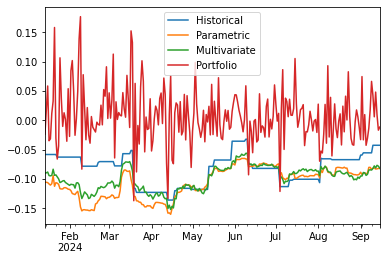

In [76]:
var_data.plot()

<AxesSubplot:>

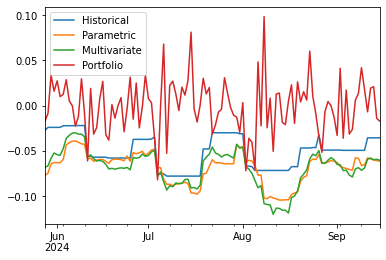

In [77]:
current_var_data.plot()

In [78]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.020325,0.012195,0.012195
Kupiec Stat,5.824076,10.499354,10.499354
P-value,0.015808,0.001194,0.001194


In [79]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.072072,0.036036,0.027027
Kupiec Stat,1.007667,0.502644,1.470059
P-value,0.315463,0.478341,0.225336


## Principal Component Analysis

### Historical PCA

In [80]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78761607, 0.06461526, 0.05318258, 0.05014678, 0.04443932])

In [81]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

1000SATSUSDT    0.023888
AAVEUSDT        0.014019
ADAUSDT         0.014077
ALGOUSDT        0.015630
APTUSDT         0.014820
                  ...   
WLDUSDT         0.021340
XECUSDT         0.015246
XLMUSDT         0.009524
XRPUSDT         0.009168
XTZUSDT         0.014252
Name: PC1, Length: 65, dtype: float64

<AxesSubplot:>

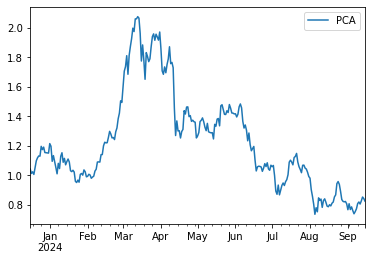

In [82]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

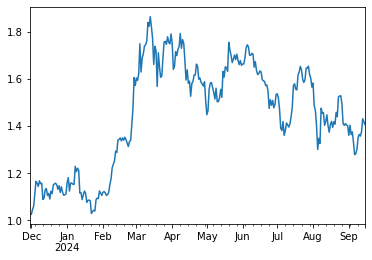

In [83]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [84]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
XTZUSDT      0.335367
ADAUSDT      0.338421
ALGOUSDT     0.349548
ETHUSDT      0.355371
               ...   
PEPEUSDT     0.990374
FLOKIUSDT    1.000838
WLDUSDT      1.022590
CKBUSDT      1.135270
OMUSDT       1.310864
Length: 66, dtype: float64

<AxesSubplot:>

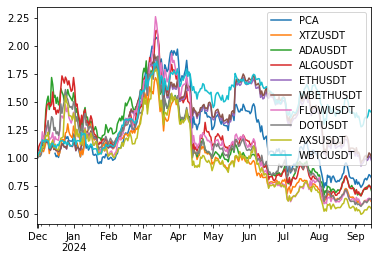

In [85]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

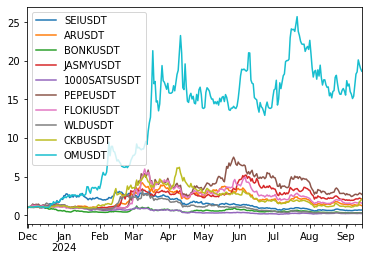

In [86]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [87]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.66960095, 0.13961991, 0.08701893, 0.07163675, 0.03212346])

In [88]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.063964
TRXUSDT      0.014827
JASMYUSDT    0.154968
SOLUSDT      0.103328
OMUSDT       0.100823
ETHUSDT      0.086011
BBUSDT       0.246863
BNBUSDT      0.067751
PEPEUSDT     0.161465
Name: PC1, dtype: float64

<AxesSubplot:>

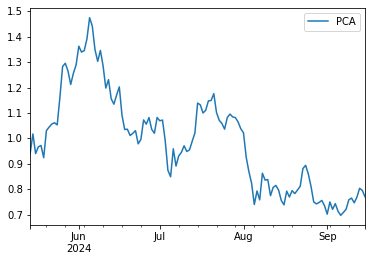

In [89]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

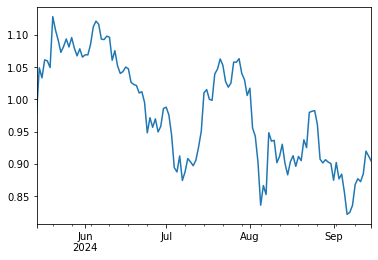

In [90]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [91]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.327034
SOLUSDT      0.336807
BNBUSDT      0.359577
BTCUSDT      0.359676
JASMYUSDT    0.420218
PEPEUSDT     0.453092
OMUSDT       0.526034
TRXUSDT      0.536121
BBUSDT       0.612020
dtype: float64

<AxesSubplot:>

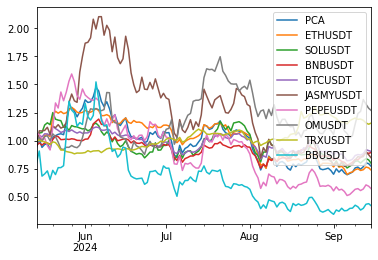

In [92]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [93]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.944016
BBUSDT       1.725290
JASMYUSDT    1.283465
SOLUSDT      1.167179
BTCUSDT      1.000000
OMUSDT       0.997473
ETHUSDT      0.956087
BNBUSDT      0.669302
TRXUSDT      0.280886
Name: BTCUSDT, dtype: float64

In [94]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       1.681126
PEPEUSDT     1.657680
OMUSDT       1.489194
SOLUSDT      1.223198
ETHUSDT      1.179886
JASMYUSDT    1.038445
BTCUSDT      1.000000
BNBUSDT      0.691291
TRXUSDT      0.107399
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [95]:
results={}
window=7

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,TRXUSDT,JASMYUSDT,SOLUSDT,OMUSDT,ETHUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-20,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-05-27,0.000000,0.000000,0.405921,0.000000,0.000000,0.000000,0.122004,0.000000,0.472076
2024-06-03,0.000000,0.000000,0.185125,0.000000,0.814875,0.000000,0.000000,0.000000,0.000000
2024-06-10,0.000000,0.841078,0.047817,0.000000,0.111105,0.000000,0.000000,0.000000,0.000000
2024-06-17,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.979868,0.000000,0.000000,0.020132,0.000000,0.000000,0.000000,0.000000
2024-07-01,0.000000,0.804372,0.000000,0.146827,0.047122,0.000000,0.001680,0.000000,0.000000
2024-07-08,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
2024-07-15,0.048111,0.606760,0.002957,0.000000,0.000000,0.000000,0.037292,0.304881,0.000000
2024-07-22,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [96]:
(rolling_optimization>0.25).sum()

BTCUSDT      0
TRXUSDT      8
JASMYUSDT    2
SOLUSDT      3
OMUSDT       3
ETHUSDT      0
BBUSDT       1
BNBUSDT      2
PEPEUSDT     1
dtype: int64